In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import bbknn

import os
import joblib

In [2]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu', figsize = (5, 5),dpi_save=300)

scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
# Choose min_dist, spread
min_dist = 0.2 # default = 0.5
spread = 1 #default = 1

## Read in all data

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 629041 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [5]:
adata.var.head(1)

,gene_name_scRNA-0,gene_name_snRNA-1,gene_name_multiome-2
ENSG00000243485,MIR1302-2HG,MIR1302-2HG,MIR1302-2HG


In [6]:
adata.obs.head(1)

,sangerID,combinedID,donor,donor_type,region,region_finest,age,gender,facility,cell_or_nuclei,...,cluster_scrublet_score,doublet_pval,doublet_bh_pval,batch_key,leiden_scVI,cell_type,cell_state_HCAv1,cell_state_scNym,cell_state_scNym_confidence,cell_state
barcode,,,,,,,,,,,,,,,,,,,,,
HCAHeart7606896_GATGAGGCACGGCTAC,HCAHeart7606896,na,D1,DBD,AX,AX,50-55,Female,Sanger,Cell,...,0.184933,0.084434,0.83272,D1_Cell_3prime-v2,21,Endothelial cell,EC5_art,nan,NaN,EC5_art


In [7]:
# replace the var_names with gene name, for both adata.var and adata.raw.var
# adata.raw.var['gene_id']=adata.raw.var_names
# adata.raw.var.set_index(genename_column, inplace=True)
genename_column='gene_name_multiome-2'

adata.var['gene_id']=adata.var_names
adata.var.set_index(genename_column, inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()

In [8]:
print(adata.shape)
adata = adata[adata.obs['region'].isin(['AVN'])]
print(adata.shape)
adata = adata[adata.obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])]
print(adata.shape)
adata = adata[adata.obs['cell_state']!='unclassified']
print(adata.shape)

(629041, 32732)
(21037, 32732)
(11264, 32732)
(11209, 32732)


In [9]:
#Add in cell_type_with_CCS_states
adata.obs['cell_type_with_CCS_states']=adata.obs['cell_type'].copy()
adata.obs['cell_type_with_CCS_states']=adata.obs['cell_type_with_CCS_states'].astype('str')

adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='SAN_P_cell']='SAN_P_cell'
adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='AVN_P_cell']='AVN_P_cell'
adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='AVN_bundle_cell']='AVN_bundle_cell'

#Add in cell_type_with_CCS_states_grouped (Pacemaker cells)
adata.obs['cell_type_with_CCS_states_grouped']=adata.obs['cell_type_with_CCS_states'].copy()
adata.obs['cell_type_with_CCS_states_grouped']=adata.obs['cell_type_with_CCS_states_grouped'].astype('str')

adata.obs['cell_type_with_CCS_states_grouped'][adata.obs['cell_state']=='SAN_P_cell']='P_cell'
adata.obs['cell_type_with_CCS_states_grouped'][adata.obs['cell_state']=='AVN_P_cell']='P_cell'

#Add in cell_type_with_CCS_states_as_block (CCS cells)
adata.obs['cell_type_with_CCS_states_as_block']=adata.obs['cell_type_with_CCS_states'].copy()
adata.obs['cell_type_with_CCS_states_as_block']=adata.obs['cell_type_with_CCS_states_as_block'].astype('str')

adata.obs['cell_type_with_CCS_states_as_block'][adata.obs['cell_state']=='SAN_P_cell']='CCS_cell'
adata.obs['cell_type_with_CCS_states_as_block'][adata.obs['cell_state']=='AVN_P_cell']='CCS_cell'
adata.obs['cell_type_with_CCS_states_as_block'][adata.obs['cell_state']=='AVN_bundle_cell']='CCS_cell'

Trying to set attribute `.obs` of view, copying.
<ipython-input-9-f7a1c65b485e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='SAN_P_cell']='SAN_P_cell'
<ipython-input-9-f7a1c65b485e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_type_with_CCS_states'][adata.obs['cell_state']=='AVN_P_cell']='AVN_P_cell'
<ipython-input-9-f7a1c65b485e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [10]:
# Since we are starting with raw object, need to perform basic QC steps
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
# normalise and logtransform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # save raw count data

In [12]:
%%time

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)

# freeze the state in `.raw`
adata.raw = adata

# subset hvgs
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.17 s, sys: 200 ms, total: 1.37 s
Wall time: 1.36 s


In [13]:
%%time
# regress out - not needed if using scVI object
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_with_CCS_states' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_with_CCS_states_grouped' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_with_CCS_states_as_block' as categorical


CPU times: user 11min 24s, sys: 13min 19s, total: 24min 44s
Wall time: 1min 15s


In [14]:
sc.pp.scale(adata, max_value=10)

In [15]:
sc.tl.pca(adata, svd_solver='arpack')

## plotting

In [16]:
%%time
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=3)

CPU times: user 25.7 s, sys: 8.2 s, total: 33.9 s
Wall time: 21 s


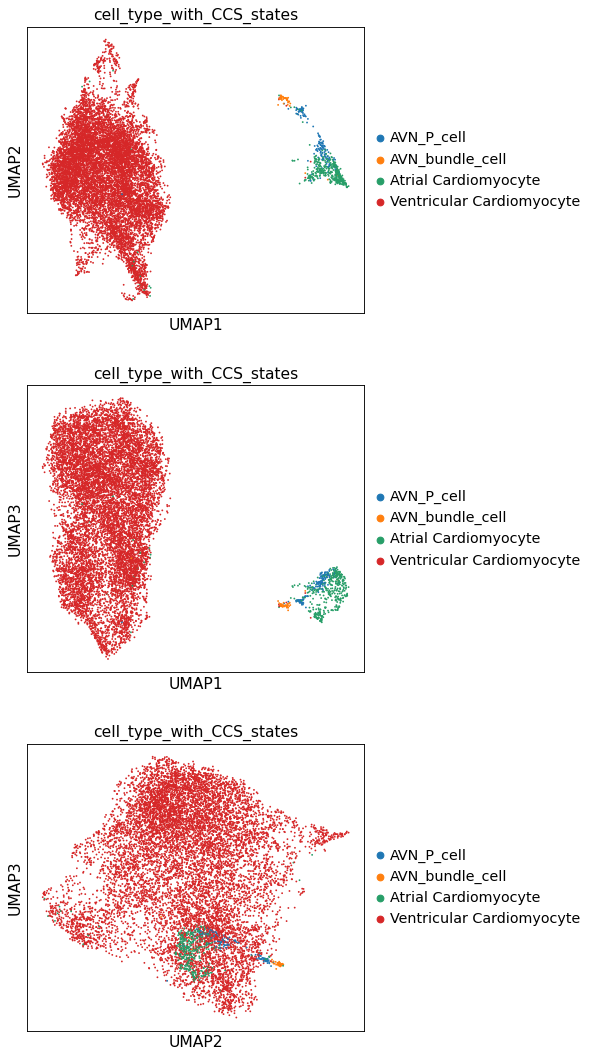

In [18]:
sc.pl.umap(adata,
           color='cell_type_with_CCS_states',
          components='all',
          ncols =1)